In [1]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def print_image(image):
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.axis('off')
  plt.show()

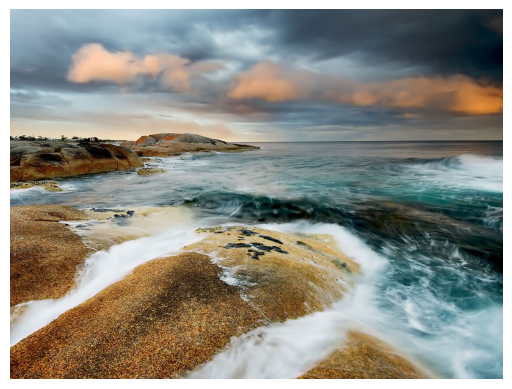

In [4]:
img=plt.imread('../src/photo_Lab4.jpg')
print_image(img)

In [5]:
def grayscale_cpu(img):
  start_t = time.time()
  Grayscale_cpu = np.zeros(img.shape, np.uint8)
  for y in range(img.shape[0]):
      for x in range(img.shape[1]):
          Grayscale_cpu[y, x] = np.mean(img[y, x])
  total_time = time.time() - start_t
  print(f"It took {total_time} s to finish.")
  return Grayscale_cpu, total_time

In [6]:
cpu_grayscale_img, cpu_time = grayscale_cpu(img)
print(f"CPU Time : {cpu_time:.5f} secondes")

It took 15.244890451431274 s to finish.
CPU Time : 15.24489 secondes


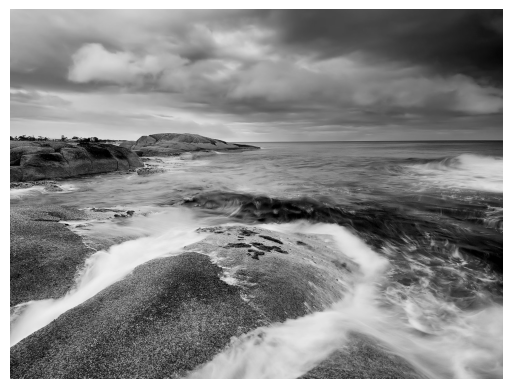

In [7]:
print_image(cpu_grayscale_img)

In [10]:
@cuda.jit
def grayscale_gpu(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) // 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

def grayscale_gpu_1d(img, blockSize=64):
  imageHeight, imageWidth, _ = img.shape
  pixelCount = imageWidth * imageHeight
  gridSize = int(pixelCount / blockSize)
  flatSrc = np.reshape(img, (pixelCount, 3))

  start_t = time.time()

  devSrc = cuda.to_device(flatSrc)
  devDst = cuda.device_array((pixelCount, 3), np.uint8)
  grayscale_gpu[gridSize, blockSize](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  gpu_time = time.time() - start_t
  print(f"GPU Time : {gpu_time:.5f} secondes")

  img = hostDst.reshape((imageHeight, imageWidth, 3))
  return img, gpu_time

GPU Time : 0.97890 secondes


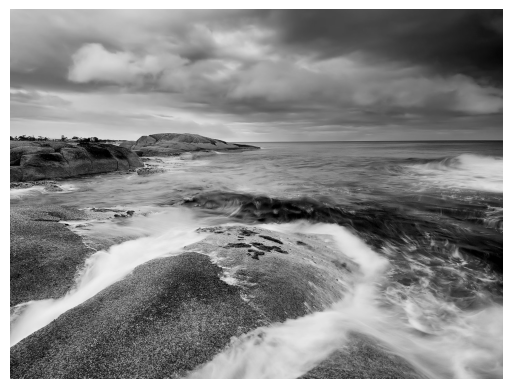

In [11]:
gpu_grayscale_img, _ = grayscale_gpu_1d(img)

print_image(gpu_grayscale_img)

In [12]:
@cuda.jit
def grayscale_2d(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint8((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
  dst[tidx, tidy, 0] = dst[tidx, tidy, 1] = dst[tidx, tidy, 2] = g

def grayscale_gpu_2d(img, blockSize=(32, 32)):
  imageHeight, imageWidth, _ = img.shape
  gridSize = (imageHeight // blockSize[0], imageWidth // blockSize[1])

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  grayscale_2d[gridSize, blockSize](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  gpu_time = time.time() - start_t
  print(f"GPU Time : {gpu_time:.5f} secondes")

  img = hostDst.reshape((imageHeight, imageWidth, 3))
  return img, gpu_time

GPU Time : 0.24875 secondes


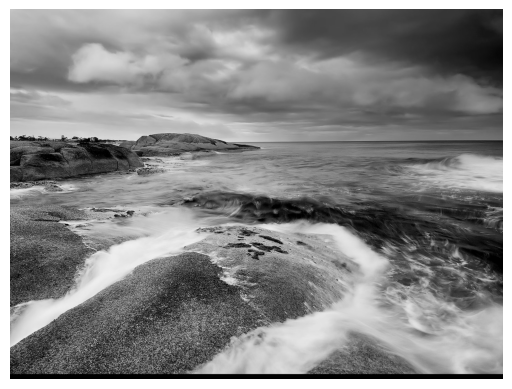

In [13]:
gpu_2D_grayscale_img, _ = grayscale_gpu_2d(img)

print_image(gpu_2D_grayscale_img)